# Interpolation with Rician Noise on DWI's

Code by:

Tyler Spears - tas6hh@virginia.edu

Dr. Tom Fletcher

---

Source works:

`Basu S, Fletcher T, Whitaker R. Rician Noise Removal in Diffusion Tensor MRI. In: Larsen R, Nielsen M, Sporring J, eds. Medical Image Computing and Computer-Assisted Intervention – MICCAI 2006. Vol 4190. Lecture Notes in Computer Science. Springer Berlin Heidelberg; 2006:117-125. doi:10.1007/11866565_15
`


# Imports & Environment Setup

## Imports

In [255]:
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 1

# imports
import collections
import itertools
import functools

import pathlib
from pathlib import Path
import shutil

import math
import random
import datetime
import time

import copy
import warnings
import pdb
import inspect
import sys

import os
import io
import subprocess

import dotenv

# Toolbelt/utility imports
import natsort
from natsort import natsorted
import addict
from addict import Addict
import pprint
from pprint import pprint as ppr

# Computation & ML libraries.
import numpy as np
import scipy
import skimage
import skimage.feature
import skimage.filters
import skimage.measure
import nibabel as nib
import dipy
import dipy.viz
import ants
import pandas as pd

import torch
import torch.nn.functional as F
import torchvision
import torchio
import pytorch_lightning as pl

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
from tabulate import tabulate
from IPython.display import display, Markdown

# Try importing GPUtil for printing GPU specs.
# May not be installed if using CPU only.
try:
    import GPUtil
except ImportError:
    warnings.warn("WARNING: Package GPUtil not found, cannot print GPU specs")

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})

# Set print options for ndarrays/tensors.
np.set_printoptions(threshold=100, linewidth=88)
torch.set_printoptions(precision=8, threshold=100, linewidth=88)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True);

direnv: loading ~/work/pitn/.envrc
direnv: creating conda environment

CondaValueError: prefix already exists: /opt/miniconda/envs/pitn



In [4]:
# Project-specific scripts
# It's easier to import it this way rather than make an entirely new package, due to
# conflicts with local packages and anaconda installations.
# You made me do this, poor python package management!!
if "PROJECT_ROOT" in os.environ:
    lib_location = str(Path(os.environ["PROJECT_ROOT"]).resolve())
else:
    lib_location = str(Path("../../").resolve())
if lib_location not in sys.path:
    sys.path.insert(0, lib_location)
import lib as pitn

# Include the top-level lib module along with its submodules.
%aimport lib
# Grab all submodules of lib, not including modules outside of the package.
includes = list(
    filter(
        lambda m: m.startswith("lib."),
        map(lambda x: x[1].__name__, inspect.getmembers(pitn, inspect.ismodule)),
    )
)
# Run aimport magic with constructed includes.
ipy = IPython.get_ipython()
ipy.run_line_magic("aimport", ", ".join(includes))

In [5]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

cuda


## Specs Recording

In [6]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash
if torch.cuda.is_available():

    # GPU information
    # Taken from
    # <https://www.thepythoncode.com/article/get-hardware-system-information-python>.
    # If GPUtil is not installed, skip this step.
    try:
        gpus = GPUtil.getGPUs()
        print("=" * 50, "GPU Specs", "=" * 50)
        list_gpus = []
        for gpu in gpus:
            # get the GPU id
            gpu_id = gpu.id
            # name of GPU
            gpu_name = gpu.name
            driver_version = gpu.driver
            cuda_version = torch.version.cuda
            # get total memory
            gpu_total_memory = f"{gpu.memoryTotal}MB"
            gpu_uuid = gpu.uuid
            list_gpus.append(
                (
                    gpu_id,
                    gpu_name,
                    driver_version,
                    cuda_version,
                    gpu_total_memory,
                    gpu_uuid,
                )
            )

        print(
            tabulate(
                list_gpus,
                headers=(
                    "id",
                    "Name",
                    "Driver Version",
                    "CUDA Version",
                    "Total Memory",
                    "uuid",
                ),
            )
        )
    except NameError:
        print("CUDA Version: ", torch.version.cuda)

else:
    print("CUDA not in use, falling back to CPU")

In [7]:
# cap is defined in an ipython magic command
print(cap)

Author: Tyler Spears

Last updated: 2021-06-15T14:01:49.446450+00:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.23.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-72-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: fe99cb7283e761f1f906ea3a1eb3da5f03d365d2

ipywidgets       : 7.6.3
pytorch_lightning: 1.3.2
matplotlib       : 3.4.1
torch            : 1.8.1
addict           : 2.4.0
torchio          : 0.18.37
json             : 2.0.9
GPUtil           : 1.4.0
torchvision      : 0.9.1
natsort          : 7.1.1
sys              : 3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
scipy            : 1.5.3
skimage          : 0.18.1
seaborn          : 0.11.1
IPython          : 7.23.1
pandas           : 1.2.3
numpy            : 1.20.2

================================================== GPU Specs ==================================================
  id  Name       Driver Version      CUDA V

## Data Variables & Definitions Setup

In [8]:
# Set up directories
data_dir = pathlib.Path(os.environ["DATA_DIR"]) / "hcp"
assert data_dir.exists()
write_data_dir = pathlib.Path(os.environ["WRITE_DATA_DIR"]) / "hcp"
assert write_data_dir.exists()
results_dir = pathlib.Path(os.environ["RESULTS_DIR"])
assert results_dir.exists()

In [9]:
# Dict to keep track of experiment configuration parameters. Will not be logged to
# tensorboard.
exp_params = Addict()

In [10]:
downsample_factor = 2
# Include b=0 shells and b=1000 shells for DTI fitting.
bval_range = (0, 1500)
dti_fit_method = "WLS"
exp_params.update(
    {
        "downsample_factor": downsample_factor,
        "bval_range": bval_range,
        "dti_fit_method": dti_fit_method,
    }
)

### Patch Parameters

In [11]:
# Patch parameters
batch_size = 64
# 6 channels for the 6 DTI components
channels = 6

# Output patch shapes
h_out = 14
w_out = 14
d_out = 14

# This is the factor that determines how over-extended the input patch should be
# relative to the size of the full-res patch.
# $low_res_patch_dim = \frac{full_res_patch_dim}{downsample_factor} \times low_res_sample_extension$
# A value of 1 indicates that the input patch dims will be exactly divided by the
# downsample factor. A dilation > 1 increases the "spatial extent" of the input
# patch, providing information outside of the target HR patch.
low_res_sample_extension = 1.57

# Output shape after shuffling.
output_patch_shape = (channels, h_out, w_out, d_out)
output_spatial_patch_shape = output_patch_shape[1:]

# Input patch parameters
h_in = round(h_out / (downsample_factor) * low_res_sample_extension)
w_in = round(w_out / (downsample_factor) * low_res_sample_extension)
d_in = round(d_out / (downsample_factor) * low_res_sample_extension)
input_patch_shape = (channels, h_in, w_in, d_in)
input_spatial_patch_shape = input_patch_shape[1:]

# Pre-shuffle output patch sizes.
unshuffled_channels_out = channels * downsample_factor ** 3
# Output before shuffling
unshuffled_output_patch_shape = (unshuffled_channels_out, h_in, w_in, d_in)

# Patch size in FR-space when accounting for the low-res over-extension/over-sampling
# factor.
fr_extension_patch_size = tuple(
    np.asarray(input_spatial_patch_shape) * downsample_factor
)
fr_extension_amount = tuple(
    np.asarray(fr_extension_patch_size) - np.asarray(output_spatial_patch_shape)
)

In [12]:
exp_params.patch.update(
    batch_size=batch_size,
    channels=channels,
    low_res_sample_extension=low_res_sample_extension,
    input_shape=input_patch_shape,
    output_shape=output_patch_shape,
)

In [13]:
# Data parameters.
num_subject_samples = 2
# Should the data be normalized as a pre-processing step?
# Can be:
# { None, "channels" }
data_norm_method = "channels"

In [14]:
exp_params.data.update(
    num_subject=num_subject_samples, data_norm_method=data_norm_method
)

### Training and Testing Setup

In [15]:
# Training/testing parameters.

# Spline interpolation baseline parameters.
spline_interp_order = 1

In [16]:
# Number of voxels to dilate the mask in FR space.
# Just make it 0.
dilation_size = 0

In [17]:
exp_params.spline.update(order=spline_interp_order)
exp_params.preproc.update(dilation_size=dilation_size)

## Function Definitions

# Data Loading

## Subject ID Selection

In [18]:
# Find data directories for each subject.
subj_dirs: dict = dict()

selected_ids = [
    "397154",
    "224022",
    "140117",
    "751348",
    "894774",
    "156637",
    "227432",
    "303624",
    "185947",
    "810439",
    "753251",
    "644246",
    "141422",
    "135528",
    "103010",
    "700634",
]

## Sub-set the chosen participants for dev and debugging!
selected_ids = random.sample(selected_ids, num_subject_samples)
warnings.warn(
    "WARNING: Sub-selecting participants for dev and debugging. "
    + f"Subj IDs selected: {selected_ids}"
)
# ### A nested warning! For debugging only.
# warnings.warn("WARNING: Mixing training and testing subjects")
# selected_ids.append(selected_ids[0])
# ###
##

selected_ids = natsorted(list(map(lambda s: int(s), selected_ids)))

for subj_id in selected_ids:
    subj_dirs[subj_id] = data_dir / f"{subj_id}/T1w/Diffusion"
    assert subj_dirs[subj_id].exists()
subj_dirs

/tmp/ipykernel_90397/2765378097.py:25: UserWarning:




{140117: PosixPath('/mnt/storage/data/pitn/hcp/140117/T1w/Diffusion'),
 894774: PosixPath('/mnt/storage/data/pitn/hcp/894774/T1w/Diffusion')}

## Loading and Preprocessing

In [19]:
# Set up the transformation pipeline.

preproc_transforms = torchio.Compose(
    [
        torchio.transforms.ToCanonical(include=("dwi", "brain_mask"), copy=False),
        pitn.transforms.BValSelectionTransform(
            bval_range=bval_range,
            bval_key="bvals",
            bvec_key="bvecs",
            include="dwi",
            copy=False,
        ),
        # Pad by the dilation factor, then dilate the mask.
        torchio.transforms.Pad(
            dilation_size,
            padding_mode=0,
            include=("dwi", "brain_mask"),
            copy=False,
        ),
        pitn.transforms.DilateMaskTransform(
            dilation_size=dilation_size, include=("brain_mask",), copy=False
        ),
        # Pad by the amount of extension voxels in FR space, so LR indices cannot
        # go out of bounds.
        torchio.transforms.Pad(
            fr_extension_amount,
            padding_mode=0,
            include=("dwi", "brain_mask"),
            copy=False,
        ),
        # Ensure FR dims are divisible by the downsample factor, to more reliably
        # convert between FR indices and LR indices.
        torchio.transforms.EnsureShapeMultiple(
            downsample_factor, method="pad", include=("dwi", "brain_mask"), copy=False
        ),
        pitn.transforms.MeanDownsampleTransform(
            downsample_factor,
            include=("dwi", "brain_mask"),
            keep={"dwi": "fr_dwi", "brain_mask": "fr_brain_mask"},
            copy=False,
        ),
        pitn.transforms.RenameImageTransform(
            {"dwi": "lr_dwi", "brain_mask": "lr_brain_mask"}, copy=False
        ),
        pitn.transforms.ImageToDictTransform(
            include=("lr_dwi", "lr_brain_mask"), copy=False
        ),
    ]
)

In [20]:
# Import all image data into a sequence of `torchio.Subject` objects.
subj_data: dict = dict()

for subj_id, subj_dir in subj_dirs.items():
    # Sub-select volumes with only bvals in a certain range. E.x. bvals <= 1100 mm/s^2,
    # a.k.a. only the b=0 and b=1000 shells.
    bvals = torch.as_tensor(np.loadtxt(subj_dir / "bvals").astype(int))
    bvecs = torch.as_tensor(np.loadtxt(subj_dir / "bvecs"))
    # Reshape to be N x 3
    if bvecs.shape[0] == 3:
        bvecs = bvecs.T

    brain_mask = torchio.LabelMap(
        subj_dir / "nodif_brain_mask.nii.gz",
        type=torchio.LABEL,
        channels_last=False,
    )
    brain_mask.set_data(brain_mask.data.bool())
    mask_volume = brain_mask["data"].sum()
    print(f"Brain mask volume before dilation: {mask_volume}")
    dwi = torchio.ScalarImage(
        subj_dir / "data.nii.gz",
        type=torchio.INTENSITY,
        bvals=bvals,
        bvecs=bvecs,
        reader=pitn.io.nifti_reader,
        channels_last=True,
    )

    subject_dict = torchio.Subject(subj_id=subj_id, dwi=dwi, brain_mask=brain_mask)
    preproced_subj = preproc_transforms(subject_dict)

    subj_data[subj_id] = preproced_subj
    print("=" * 20)
#     breakpoint()

print("===Data Loaded & Transformed===")

Brain mask volume before dilation: 730310
Loading NIFTI image: /mnt/storage/data/pitn/hcp/140117/T1w/Diffusion/data.nii.gz
	Loaded NIFTI image
Selecting with bvals: Subject 140117...Selected
Downsampling: Subject 140117...Downsampled
Brain mask volume before dilation: 865379
Loading NIFTI image: /mnt/storage/data/pitn/hcp/894774/T1w/Diffusion/data.nii.gz
	Loaded NIFTI image
Selecting with bvals: Subject 894774...Selected
Downsampling: Subject 894774...Downsampled
===Data Loaded & Transformed===


## Load UVA Data

In [153]:
# Load the UVA subject data
uva_data_dir = pathlib.Path(os.environ["DATA_DIR"]) / "uva"
assert uva_data_dir.exists()
uva_subj_dirs = dict()

for subj_dir in uva_data_dir.glob("*"):
    subj_id = subj_dir.name
    uva_subj_dirs[subj_id] = uva_data_dir / subj_id
    assert uva_subj_dirs[subj_id].exists()
uva_subj_dirs

{'001': PosixPath('/mnt/storage/data/pitn/uva/001')}

In [315]:
uva_subj_data: dict = dict()

for subj_id, subj_dir in uva_subj_dirs.items():
    # Sub-select volumes with only bvals in a certain range. E.x. bvals <= 1100 mm/s^2,
    # a.k.a. only the b=0 and b=1000 shells.
    bvals_file = list(subj_dir.glob("*.bval"))[0]
    bvecs_file = list(subj_dir.glob("*.bvec"))[0]
    bvals = torch.as_tensor(np.loadtxt(bvals_file).astype(int))
    bvecs = torch.as_tensor(np.loadtxt(bvecs_file))
    # Reshape to be N x 3
    if bvecs.shape[0] == 3:
        bvecs = bvecs.T

    dwi_file = list(subj_dir.glob("*dwi.nii.gz"))[0]
    dwi = torchio.ScalarImage(
        dwi_file,
        type=torchio.INTENSITY,
        bvals=bvals,
        bvecs=bvecs,
        reader=pitn.io.nifti_reader,
        channels_last=True,
    )

    gtab = dipy.core.gradients.gradient_table(bvals, bvecs)

    _, threshold_brain_mask = dipy.segment.mask.median_otsu(
        np.moveaxis(dwi.tensor.numpy(), 0, -1),
        vol_idx=np.where(bvals == 0)[0],
        median_radius=3,
        numpass=1,
        dilate=None,
    )

    brain_mask = torchio.LabelMap(
        tensor=torch.as_tensor(threshold_brain_mask[None, ...]),
        affine=dwi.affine,
        type=torchio.LABEL,
    )
    brain_mask.set_data(brain_mask.data.bool())

    subject_dict = torchio.Subject(subj_id=subj_id, dwi=dwi, brain_mask=brain_mask)
    preproced_subj = preproc_transforms(subject_dict)

    uva_subj_data[subj_id] = preproced_subj
    print("=" * 20)

Loading NIFTI image: /mnt/storage/data/pitn/uva/001/sub-001_ses-01_run-2_dwi.nii.gz
	Loaded NIFTI image
Selecting with bvals: Subject 001...Selected
Downsampling: Subject 001...Downsampled


In [293]:
# Visualization of UVA data
subj = uva_subj_data["001"]
dwi = subj.fr_dwi.tensor.numpy()
affine = subj.fr_dwi.affine
bvals = subj.fr_dwi["bvals"].numpy()
bvecs = subj.fr_dwi["bvecs"].numpy()

gtab = dipy.core.gradients.gradient_table(bvals, bvecs)

mask_data, mask = dipy.segment.mask.median_otsu(
    np.moveaxis(dwi, 0, -1),
    vol_idx=np.where(bvals == 0)[0],
    median_radius=3,
    numpass=1,
    dilate=2,
)

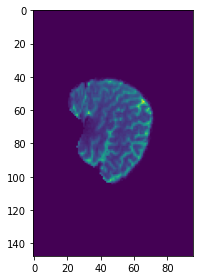

In [301]:
plt.imshow((mask[50, :, :]) * dwi[0, 50])

# Rician Noise Definitions

$ \log p(x ; \nu) = \log \frac{x}{\sigma^2} -\frac{x^2 + \nu^2}{2\sigma^2} +
\log I_0\left(\frac{x\nu}{\sigma^2}\right) $

In [ ]:
# def log_likelihood(x, signal, noise_var):
#     result = np.log(x / noise_var)
#     result = result - (x ** 2 + signal ** 2) / (2 * noise_var)
#     result = result + np.log(scipy.special.i0(x * signal / noise_var))

#     return result


# def weight_ll(patch, interp_kernel, pred_val, noise_var):
#     """
#     Find weighted log-likelihood for one voxel given several voxels in a patch.

#     Parameters:
#         patche: D_1 x D_2 x ... x D_m
#         interp_kernel: D_1 x D_2 x ... x D_m, with values that sum to 1.0
#         pred_val: float
#         noise_var: float
#     """

#     samples = patch.flatten()
#     log_likes = log_likelihood(samples, pred_val, noise_var)

#     weights = interp_kernel.flatten()
#     weight_log_likes = np.sum(weights * log_likes)

#     return weight_log_likes


# def grad_weight_ll(samples, signal, noise_var):
#     samples = samples.flatten()
#     N = len(samples)

#     offset_term = -N * signal / noise_var
#     inner_sum = (
#         scipy.special.i1(samples * signal / noise_var)
#         / scipy.special.i0(samples * signal / noise_var)
#         * samples
#         / noise_var
#     )

#     sum_term = np.sum(inner_sum)
#     result = offset_term + sum_term

#     return result

$$
v_{t+1} = \mu * v_{t} + g_{t+1}, \\
p_{t+1} = p_{t} - \text{lr} * v_{t+1}
$$

In [ ]:
# def grad_interpolate(
#     patch,
#     interp_kernel,
#     noise_var,
#     lr,
#     momentum=0,
#     init_pred=None,
#     tol=1e-5,
#     max_steps=1000,
# ):
#     samples = patch.flatten()
#     weights = interp_kernel.flatten()
#     if init_pred is None:
#         init_pred = np.sum(samples * weights)

#     pred_t = init_pred
#     vel_t = 1 * momentum

#     for i in range(max_steps):
#         grad_tp1 = grad_weight_ll(samples, pred_t, noise_var)
#         if grad_tp1 <= tol:
#             return pred_t

#         vel_tp1 = momentum * vel_t + grad_tp1
#         pred_tp1 = pred_t - lr * vel_tp1

#         pred_t = pred_tp1
#         vel_t = vel_tp1

#     print(f"WARNING: Did not converge to tol {tol}")

#     return pred_t

# Interpolation with Pytorch Modules

In [139]:
# class RicianNLL(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, pred_signals, samples, weights, noise_var):
#         """

#         Parameters:
#             samples: torch.Tensor with shape B x N
#             pred_signals: torch.Tensor with shape B
#             weights: torch.Tensor with shape B x N
#             noise_var: float
#         """
#         # ctx is a context object that can be used to stash information
#         # for backward computation
#         ctx.noise_var = noise_var
#         ctx.samples = samples
#         ctx.pred_signals = pred_signals

# #         breakpoint()

#         log_likes = torch.log(samples / noise_var)
#         log_likes = log_likes - (samples ** 2 + pred_signals.view(-1, 1) ** 2) / (
#             2 * noise_var
#         )

#         zero_bessel = scipy.special.i0(
#             (samples * pred_signals.view(-1, 1) / noise_var).cpu().numpy()
#         )
#         zero_bessel = torch.as_tensor(zero_bessel).to(log_likes)
#         ctx.zero_bessel = zero_bessel

#         log_likes = log_likes + torch.log(zero_bessel)

#         weight_log_likes = torch.sum(weights * log_likes, dim=1)

#         return -weight_log_likes

#     @staticmethod
#     def backward(ctx, grad_output):
#         # We return as many input gradients as there were arguments.
#         # Gradients of non-Tensor arguments to forward must be None.
#         samples = ctx.samples
#         N = len(samples)
#         pred_signals = ctx.pred_signals
#         noise_var = ctx.noise_var

#         offset_term = -N * pred_signals / noise_var

#         zero_bessel = ctx.zero_bessel
#         one_bessel = scipy.special.i1(
#             (samples * pred_signals.view(-1, 1) / noise_var).cpu().numpy()
#         )
#         one_bessel = torch.as_tensor(one_bessel).to(zero_bessel)

#         inner_sum = one_bessel / zero_bessel * samples / noise_var

#         sum_term = torch.sum(inner_sum, dim=1)
#         grads = offset_term + sum_term

#         return grads, None, None, None


# class RicianInterp(torch.nn.Module):
#     def __init__(self, init_signals):
#         super().__init__()

#         self.N = len(init_signals)
#         self.signals = torch.nn.Parameter(torch.as_tensor(init_signals))

#     def forward(
#         self, patches: torch.Tensor, interp_kernels: torch.Tensor, noise_var: float
#     ):
#         if interp_kernels.ndim == patches.ndim - 1:
#             interp_kernels = interp_kernels.expand_as(patches)

#         samples = patches.reshape(self.N, -1)
#         interp_kernels = interp_kernels.reshape(self.N, -1)

#         return RicianNLL.apply(self.signals, samples, interp_kernels, noise_var)

In [146]:
# B = 2
# N = 3
# test_input = torch.as_tensor([[0.1, 1.0, 1.3], [2., 4., 0.3]], dtype=float)
# kernel = torch.as_tensor([0.5, 0.3, 0.2]).float()
# noise_var = test_input.var()
# pred = (test_input * kernel).sum(dim=1)
# pred.requires_grad_(True)

# r_interp = RicianInterp(pred)
# out = r_interp(test_input, kernel, noise_var)
# out

# optimizer = torch.optim.SGD(r_interp.parameters(), lr=0.01)

# for _ in range(10):
#     w_nlls = r_interp(test_input, kernel, noise_var)
#     loss = w_nlls.sum()
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     print(loss)

tensor(3.82369042, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3.82414941, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3.82462049, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3.82510386, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3.82559976, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3.82610838, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3.82662997, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3.82716474, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3.82771292, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3.82827475, dtype=torch.float64, grad_fn=<SumBackward0>)


In [135]:
test_input = np.asarray([0.1, 1.0, 1.3])
kernel = np.asarray([0.5, 0.3, 0.2])
noise_var = test_input.var()
pred = np.sum(test_input * kernel)

mle, _, _ = scipy.stats.rice.fit(test_input, pred, floc=0, fscale=np.sqrt(noise_var))
print(mle, pred)